In [1]:
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings("ignore")
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib import colormaps
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [2]:
nhis_diabetes_data= pd.read_csv("nhis_2022.csv")  
nhis_diabetes_data.columns

Index(['YEAR', 'SERIAL', 'STRATA', 'PSU', 'NHISHID', 'REGION', 'PERNUM',
       'NHISPID', 'HHX', 'SAMPWEIGHT', 'ASTATFLG', 'CSTATFLG', 'AGE', 'SEX',
       'MARSTCUR', 'EDUC', 'HOURSWRK', 'POVERTY', 'HEIGHT', 'WEIGHT',
       'BMICALC', 'HINOTCOVE', 'CANCEREV', 'CHEARTDIEV', 'DIABETICEV',
       'HEARTATTEV', 'STROKEV', 'ALCANYNO', 'ALCDAYSYR', 'CIGDAYMO',
       'MOD10DMIN', 'VIG10DMIN', 'FRUTNO', 'VEGENO', 'JUICEMNO', 'SALADSNO',
       'BEANNO', 'SALSAMNO', 'TOMSAUCEMNO', 'SODAPNO', 'FRIESPNO', 'SPORDRMNO',
       'FRTDRINKMNO', 'COFETEAMNO', 'POTATONO', 'PIZZANO', 'HRSLEEP',
       'CVDSHT'],
      dtype='object')

In [3]:
selected_data = nhis_diabetes_data[['DIABETICEV', 'AGE', 'BMICALC', 'HRSLEEP', 'SEX', 'SODAPNO']]
selected_data = selected_data[
    (selected_data['AGE'] < 996) &
    (selected_data['BMICALC'] < 996) &
    (selected_data['HRSLEEP'] < 996) &
    (selected_data['SODAPNO'] < 996)
]
selected_data.isnull().sum()
selected_data = selected_data.dropna()


In [4]:
# Step 1: Filter DIABETICEV (1:0 No and 2:1 Yes)
selected_filtered_data = selected_data[selected_data['DIABETICEV'].isin([1, 2])]
selected_filtered_data['DIABETICEV'] = selected_filtered_data['DIABETICEV'].replace({1: 0, 2: 1})

# Step 2: Filter SEX (1:0 Male and 2:1 Female)
selected_filtered_data = selected_filtered_data[selected_filtered_data['SEX'].isin([1, 2])]
selected_filtered_data['SEX'] = selected_filtered_data['SEX'].replace({1: 0, 2: 1})

# Step 3: Filter out invalid AGE values (keep AGE < 996)
selected_filtered_data = selected_filtered_data[selected_filtered_data['AGE'] < 996]

# Step 4: Filter out invalid BMI (BMICALC < 996)
selected_filtered_data = selected_filtered_data[selected_filtered_data['BMICALC'] < 996]

# Step 5: Filter out invalid HRSLEEP values (remove 97, 98, 99)
selected_filtered_data = selected_filtered_data[~selected_filtered_data['HRSLEEP'].isin([97, 98, 99])]

# Step 6: Filter out invalid SODAPNO values (SODAPNO < 996)
selected_filtered_data = selected_filtered_data[selected_filtered_data['SODAPNO'] < 996]

# Step 7: Drop any remaining NaN (safe check)
selected_filtered_data = selected_filtered_data.dropna()

# Step 8: Final check
print(selected_filtered_data.info())
print(selected_filtered_data.head())


<class 'pandas.core.frame.DataFrame'>
Index: 24205 entries, 0 to 35113
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DIABETICEV  24205 non-null  int64  
 1   AGE         24205 non-null  int64  
 2   BMICALC     24205 non-null  float64
 3   HRSLEEP     24205 non-null  int64  
 4   SEX         24205 non-null  int64  
 5   SODAPNO     24205 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 1.3 MB
None
   DIABETICEV  AGE  BMICALC  HRSLEEP  SEX  SODAPNO
0           0   61     38.4        8    0        0
1           0   43     27.3        6    0        0
3           0   68     25.0        6    0        1
4           0   73     24.0        8    0       30
6           0   73     26.5        6    0        5


In [5]:
print(selected_filtered_data['DIABETICEV'].value_counts())


DIABETICEV
0    21700
1     2505
Name: count, dtype: int64


In [6]:
#Performing Sampling to Balance the Dataset-undersampling
from sklearn.utils import resample

# Separate majority and minority classes
no_diabetes = selected_filtered_data[selected_filtered_data['DIABETICEV'] == 0]
yes_diabetes = selected_filtered_data[selected_filtered_data['DIABETICEV'] == 1]

# Downsample majority class (No diabetes)
no_diabetes_downsampled = resample(no_diabetes,replace=False, n_samples=len(yes_diabetes), random_state=42)

# Combine minority class with downsampled majority class
balanced_data = pd.concat([no_diabetes_downsampled, yes_diabetes])

# Shuffle the balanced dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new class balance
print(balanced_data['DIABETICEV'].value_counts())


DIABETICEV
0    2505
1    2505
Name: count, dtype: int64


In [7]:
# Define X and y from the BALANCED data
X = balanced_data[['AGE', 'BMICALC', 'HRSLEEP', 'SEX', 'SODAPNO']]
y = balanced_data['DIABETICEV']

# Split into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# Scale the predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


###SVM-LINEAR

In [8]:
svm_model_linear =  SVC(kernel='linear', C = 1, cache_size = 1000, verbose = True, max_iter = 100000,random_state=42 )
svm_model_linear.fit(X_train_scaled, y_train)

[LibSVM]

SVC(C=1, cache_size=1000, kernel='linear', max_iter=100000, random_state=42,
    verbose=True)

In [9]:
#Prediction on train set
y_pred_train_linear = svm_model_linear.predict(X_train_scaled)

print("Training Set Classification Report: LINEAR")
print(classification_report(y_train, y_pred_train_linear, target_names=['No Diabetes', 'Yes Diabetes']))
accuracy = accuracy_score(y_train, y_pred_train_linear)
print("LINEAR-Training Set Accuracy:", accuracy)

Training Set Classification Report: LINEAR
              precision    recall  f1-score   support

 No Diabetes       0.75      0.62      0.68      1736
Yes Diabetes       0.68      0.79      0.73      1771

    accuracy                           0.71      3507
   macro avg       0.71      0.71      0.70      3507
weighted avg       0.71      0.71      0.70      3507

LINEAR-Training Set Accuracy: 0.7068719703450242


In [10]:
# Predictions on the Test Set
y_pred_test_linear = svm_model_linear.predict(X_test_scaled)

print("Testing Set Classification Report: LINEAR")
print(classification_report(y_test, y_pred_test_linear, target_names=['No Diabetes', 'Yes Diabetes']))
accuracy = accuracy_score(y_test, y_pred_test_linear)
print("LINEAR-Testing Set Accuracy:", accuracy)


Testing Set Classification Report: LINEAR
              precision    recall  f1-score   support

 No Diabetes       0.73      0.63      0.67       769
Yes Diabetes       0.66      0.75      0.70       734

    accuracy                           0.69      1503
   macro avg       0.69      0.69      0.69      1503
weighted avg       0.69      0.69      0.69      1503

LINEAR-Testing Set Accuracy: 0.688622754491018


In [11]:
#Performing training and testing error
y_pred_train_linear = svm_model_linear.predict(X_train_scaled)
y_pred_test_linear = svm_model_linear.predict(X_test_scaled)

training_accuracy = accuracy_score(y_train, y_pred_train_linear)
test_accuracy = accuracy_score(y_test, y_pred_test_linear)

training_error = 1 - training_accuracy
testing_error = 1 - test_accuracy

print("LINEAR-Training Error:", training_error)
print("LINEAR-Test Error:", testing_error)


LINEAR-Training Error: 0.29312802965497575
LINEAR-Test Error: 0.31137724550898205


In [12]:
#Performing with different c values
C_values = [0.01, 0.1, 1, 10, 100]
results = []

for C in C_values:
    svm_model_tune_linear = SVC(kernel='linear', C=C)
    svm_model_tune_linear.fit(X_train_scaled, y_train)
    
    accuracy = svm_model_tune_linear.score(X_test_scaled, y_test)
    results.append((C, accuracy))
    print('C = {}, Accuracy: {:.4f}'.format(C, accuracy))

# Find the best C based on maximum accuracy
best_C, best_accuracy = max(results, key=lambda x: x[1])

print("Best C:", best_C)
print("Best Test Accuracy:", best_accuracy)

   

C = 0.01, Accuracy: 0.6886
C = 0.1, Accuracy: 0.6873
C = 1, Accuracy: 0.6886
C = 10, Accuracy: 0.6886
C = 100, Accuracy: 0.6886
Best C: 0.01
Best Test Accuracy: 0.688622754491018


In [13]:
#Train and Evaluate Final linear Model Using Best C
svm_model_tuned_linear = SVC(kernel='linear', C=best_C)
svm_model_tuned_linear.fit(X_train_scaled, y_train)

y_pred_train_tuned_linear = svm_model_tuned_linear.predict(X_train_scaled)
y_pred_test_tuned_linear = svm_model_tuned_linear.predict(X_test_scaled)

training_accuracy_tuned_linear= accuracy_score(y_train, y_pred_train_tuned_linear)
testing_accuracy_tuned_linear = accuracy_score(y_test, y_pred_test_tuned_linear)

training_error_tuned_linear = 1 - training_accuracy_tuned_linear
testing_error_tuned_linear= 1 - testing_accuracy_tuned_linear

print("\nClassification Report on Training Set (Tuned Model): LINEAR")
print(classification_report(y_train, y_pred_train_tuned_linear, target_names=['No Diabetes', 'Yes Diabetes']))

print("LINEAR-Tuned Model Training Accuracy:", training_accuracy_tuned_linear)

print("\nClassification Report on Test Set (Tuned Model): LINEAR")
print(classification_report(y_test, y_pred_test_tuned_linear, target_names=['No Diabetes', 'Yes Diabetes']))

print("LINEAR-Tuned Model Training Accuracy:", testing_accuracy_tuned_linear)


print("\nLINEAR-Tuned Model Training Error:", training_error_tuned_linear)
print("LINEAR-Tuned Model Test Error:", testing_error_tuned_linear)


Classification Report on Training Set (Tuned Model): LINEAR
              precision    recall  f1-score   support

 No Diabetes       0.75      0.61      0.67      1736
Yes Diabetes       0.68      0.80      0.73      1771

    accuracy                           0.71      3507
   macro avg       0.71      0.71      0.70      3507
weighted avg       0.71      0.71      0.70      3507

LINEAR-Tuned Model Training Accuracy: 0.7060165383518677

Classification Report on Test Set (Tuned Model): LINEAR
              precision    recall  f1-score   support

 No Diabetes       0.73      0.62      0.67       769
Yes Diabetes       0.66      0.76      0.71       734

    accuracy                           0.69      1503
   macro avg       0.69      0.69      0.69      1503
weighted avg       0.69      0.69      0.69      1503

LINEAR-Tuned Model Training Accuracy: 0.688622754491018

LINEAR-Tuned Model Training Error: 0.29398346164813227
LINEAR-Tuned Model Test Error: 0.31137724550898205


In [14]:
y_pred_test_tuned_linear = svm_model_tuned_linear.predict(X_test_scaled)
conf_matrix = confusion_matrix(y_test, y_pred_test_tuned_linear)
print("Confusion Matrix: LINEAR")
print(conf_matrix)

Confusion Matrix: LINEAR
[[475 294]
 [174 560]]


Test Accuracy on Sampled Data: 0.7333


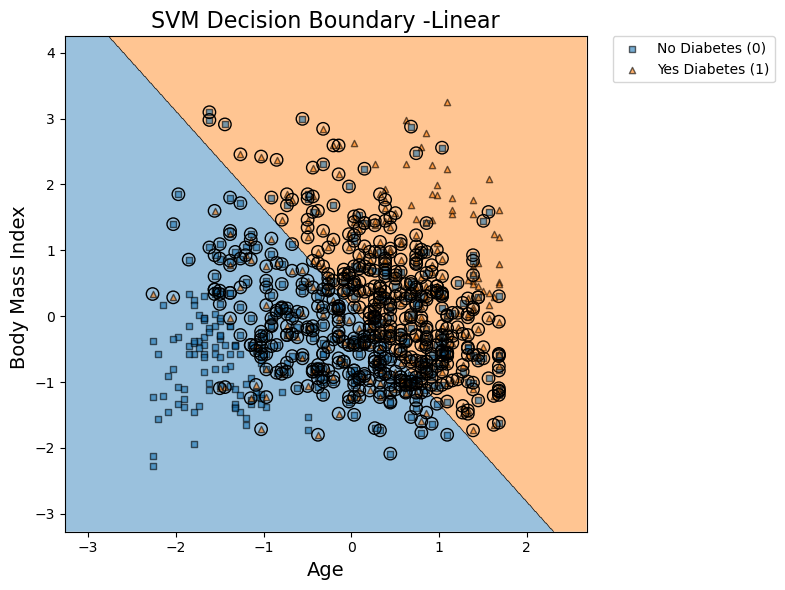

Test Accuracy on Sampled Data: 0.7033


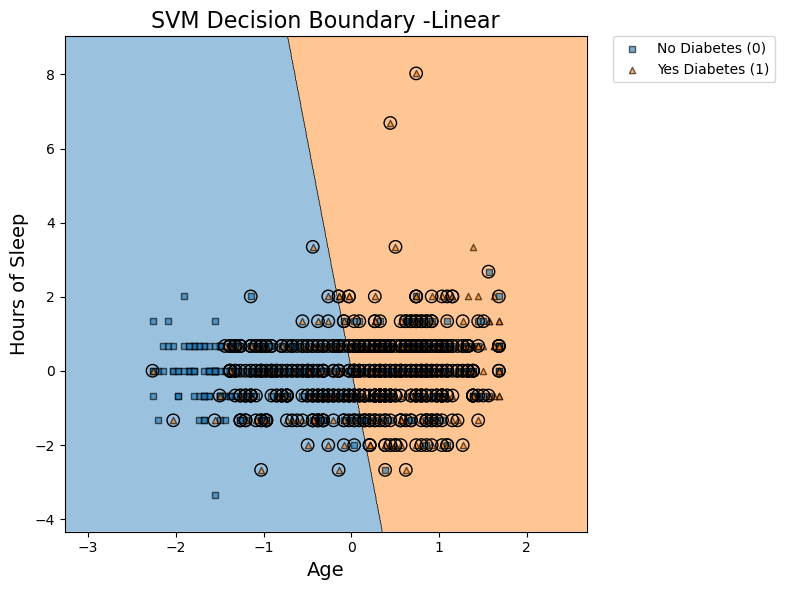

In [15]:

readable_labels = {
    'AGE': 'Age',
    'BMICALC': 'Body Mass Index ',
    'HRSLEEP': 'Hours of Sleep',
    'DIABETICEV': 'Diabetes Status'
}
def plot_decision_regions_with_accuracy(data, feature1, feature2, target):
    X = data[[feature1, feature2]]
    y = data[target]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # SVM Model
    svm_model = SVC(kernel='linear', C=best_C)
    svm_model.fit(X_train_scaled, y_train)

    # Accuracy on the test set
    y_pred_test = svm_model.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    print(f"Test Accuracy on Sampled Data: {test_accuracy:.4f}")

    # Plotting the decision boundary
    plt.figure(figsize=(8, 6))
    plot_decision_regions(X_train_scaled, y_train.to_numpy(), clf=svm_model,
                          legend=2, hide_spines=False,
                          X_highlight=svm_model.support_vectors_,
                          scatter_kwargs={'s': 20, 'edgecolor': 'k', 'alpha': 0.6})

    plt.xlabel(readable_labels.get(feature1, feature1), fontsize=14)
    plt.ylabel(readable_labels.get(feature2, feature2), fontsize=14)
    plt.title('SVM Decision Boundary -Linear', fontsize=16)
    plt.xlim(X_train_scaled[:, 0].min() - 1, X_train_scaled[:, 0].max() + 1)
    plt.ylim(X_train_scaled[:, 1].min() - 1, X_train_scaled[:, 1].max() + 1)
    plt.legend(['No Diabetes (0)', 'Yes Diabetes (1)'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()

# Sampling 1000 rows randomly from the full cleaned dataset
sampled_data = balanced_data.sample(n=1000, random_state=42)

plot_decision_regions_with_accuracy(sampled_data, 'AGE', 'BMICALC', 'DIABETICEV')
plot_decision_regions_with_accuracy(sampled_data, 'AGE', 'HRSLEEP', 'DIABETICEV')



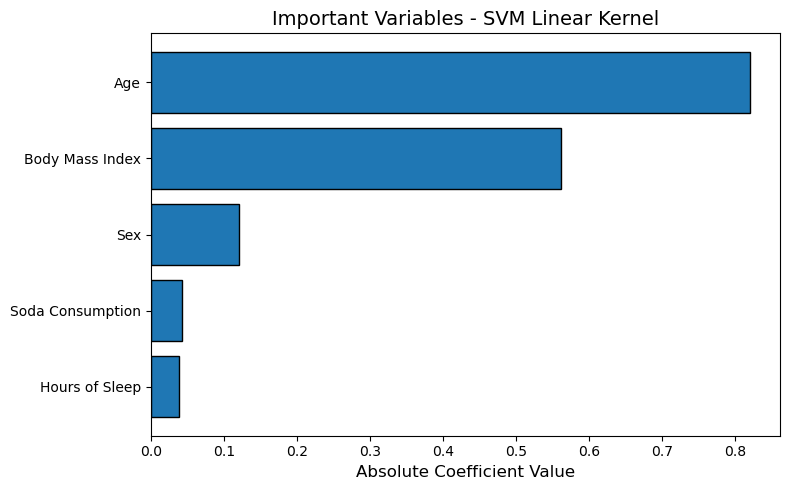

In [16]:
# Get the absolute value of the coefficients from the tuned linear model
feature_importance = np.abs(svm_model_tuned_linear.coef_[0])

# Define the feature names
feature_names = ['Age', 'Body Mass Index', 'Hours of Sleep', 'Sex', 'Soda Consumption']

# Create a DataFrame to sort features easily
importance_df = pd.DataFrame({ 'Feature': feature_names,'Importance': feature_importance})

# Sort features from most important to least important
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# Plot the feature importances
plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'], edgecolor='black')
plt.xlabel('Absolute Coefficient Value', fontsize=12)  
plt.title('Important Variables - SVM Linear Kernel', fontsize=14) 
plt.tight_layout()
plt.show()


###SVM-RADIAL

In [17]:
svm_model_radial = SVC(kernel='rbf', C=1, gamma='scale', cache_size=1000, verbose=True, max_iter=100000 )
svm_model_radial.fit(X_train_scaled, y_train)

[LibSVM]

SVC(C=1, cache_size=1000, max_iter=100000, verbose=True)

In [18]:
from sklearn.metrics import classification_report

# Make predictions on the training set
y_pred_train_radial = svm_model_radial.predict(X_train_scaled)

# Print the classification report
print("Training Set Classification Report: RADIAL")
print(classification_report(y_train, y_pred_train_radial, target_names=['No Diabetes', 'Yes Diabetes']))
accuracy = accuracy_score(y_train, y_pred_train_radial)
print("RADIAL-Training Set Accuracy:", accuracy)



Training Set Classification Report: RADIAL
              precision    recall  f1-score   support

 No Diabetes       0.76      0.63      0.69      1736
Yes Diabetes       0.69      0.81      0.74      1771

    accuracy                           0.72      3507
   macro avg       0.72      0.72      0.72      3507
weighted avg       0.72      0.72      0.72      3507

RADIAL-Training Set Accuracy: 0.7179925862560593


In [19]:
# Predictions on the Test Set
y_pred_test_radial = svm_model_radial.predict(X_test_scaled)

print("Testing Set Classification Report: RADIAL")
print(classification_report(y_test, y_pred_test_radial, target_names=['No Diabetes', 'Yes Diabetes']))
accuracy = accuracy_score(y_test, y_pred_test_radial)
print("RADIAL-Testing Set Accuracy:", accuracy)


Testing Set Classification Report: RADIAL
              precision    recall  f1-score   support

 No Diabetes       0.75      0.62      0.68       769
Yes Diabetes       0.66      0.78      0.72       734

    accuracy                           0.70      1503
   macro avg       0.71      0.70      0.70      1503
weighted avg       0.71      0.70      0.70      1503

RADIAL-Testing Set Accuracy: 0.7012641383898869


In [20]:
#Performing training and testing error
y_pred_train_radial = svm_model_radial.predict(X_train_scaled)
y_pred_test_radial = svm_model_radial.predict(X_test_scaled)

training_accuracy = accuracy_score(y_train, y_pred_train_radial)
test_accuracy = accuracy_score(y_test, y_pred_test_radial)

training_error = 1 - training_accuracy
test_error = 1 - test_accuracy

print("RADIAL-Training Error:", training_error)
print("RADIAL-Test Error:", test_error)


RADIAL-Training Error: 0.28200741374394067
RADIAL-Test Error: 0.2987358616101131


In [21]:
#Performing with different c values
C_values = [0.01, 0.1, 1, 10, 100]
results=[]
# Train the SVM model with an RBF kernel
for C in C_values:
    svm_model_tune_radial = SVC(kernel='rbf', C=C)
    svm_model_tune_radial.fit(X_train_scaled, y_train)

    accuracy = svm_model_tune_radial.score(X_test_scaled, y_test)
    results.append((C, accuracy))
    print('C = {}, Accuracy: {:.4f}'.format(C, accuracy))

# Find the best C based on maximum accuracy
best_C, best_accuracy = max(results, key=lambda x: x[1])

print("Best C:", best_C)
print("Best Test Accuracy:", best_accuracy)


C = 0.01, Accuracy: 0.6919
C = 0.1, Accuracy: 0.7019
C = 1, Accuracy: 0.7013
C = 10, Accuracy: 0.6939
C = 100, Accuracy: 0.6946
Best C: 0.1
Best Test Accuracy: 0.7019294743845642


In [22]:
#Train and Evaluate Final linear Model Using Best C
svm_radial_tuned_model= SVC(kernel='rbf', C=best_C)
svm_radial_tuned_model.fit(X_train_scaled, y_train)

y_pred_train_tuned_radial  = svm_radial_tuned_model.predict(X_train_scaled)
y_pred_test_tuned_radial = svm_radial_tuned_model.predict(X_test_scaled)

training_accuracy_tuned_radial = accuracy_score(y_train, y_pred_train_tuned_radial)
testing_accuracy_tuned_radial= accuracy_score(y_test, y_pred_test_tuned_radial)

training_error_tuned_radial = 1 - training_accuracy_tuned_radial
testing_error_tuned_radial = 1 - testing_accuracy_tuned_radial

print("\nClassification Report on Training Set (Tuned Model): RADIAL")
print(classification_report(y_train, y_pred_train_tuned_radial, target_names=['No Diabetes', 'Yes Diabetes']))

print("RADIAL-Tuned Model Training Accuracy:", training_accuracy_tuned_radial)

print("\nClassification Report on Test Set (Tuned Model): RADIAL")
print(classification_report(y_test, y_pred_test_tuned_radial, target_names=['No Diabetes', 'Yes Diabetes']))

print("RADIAL-Tuned Model Test Accuracy:", testing_accuracy_tuned_radial)

print("\nRADIAL-Tuned Model Training Error:", training_error_tuned_radial)
print("RADIAL-Tuned Model Test Error:", testing_error_tuned_radial)


Classification Report on Training Set (Tuned Model): RADIAL
              precision    recall  f1-score   support

 No Diabetes       0.76      0.61      0.68      1736
Yes Diabetes       0.68      0.81      0.74      1771

    accuracy                           0.71      3507
   macro avg       0.72      0.71      0.71      3507
weighted avg       0.72      0.71      0.71      3507

RADIAL-Tuned Model Training Accuracy: 0.711149130310807

Classification Report on Test Set (Tuned Model): RADIAL
              precision    recall  f1-score   support

 No Diabetes       0.76      0.61      0.68       769
Yes Diabetes       0.66      0.80      0.72       734

    accuracy                           0.70      1503
   macro avg       0.71      0.70      0.70      1503
weighted avg       0.71      0.70      0.70      1503

RADIAL-Tuned Model Test Accuracy: 0.7019294743845642

RADIAL-Tuned Model Training Error: 0.28885086968919305
RADIAL-Tuned Model Test Error: 0.2980705256154358


In [23]:
y_pred_test_tuned_radial = svm_radial_tuned_model.predict(X_test_scaled)
conf_matrix = confusion_matrix(y_test, y_pred_test_tuned_radial)
print("Confusion Matrix: RADIAL")
print(conf_matrix)

Confusion Matrix: RADIAL
[[469 300]
 [148 586]]


Test Accuracy on Sampled Data: 0.6967


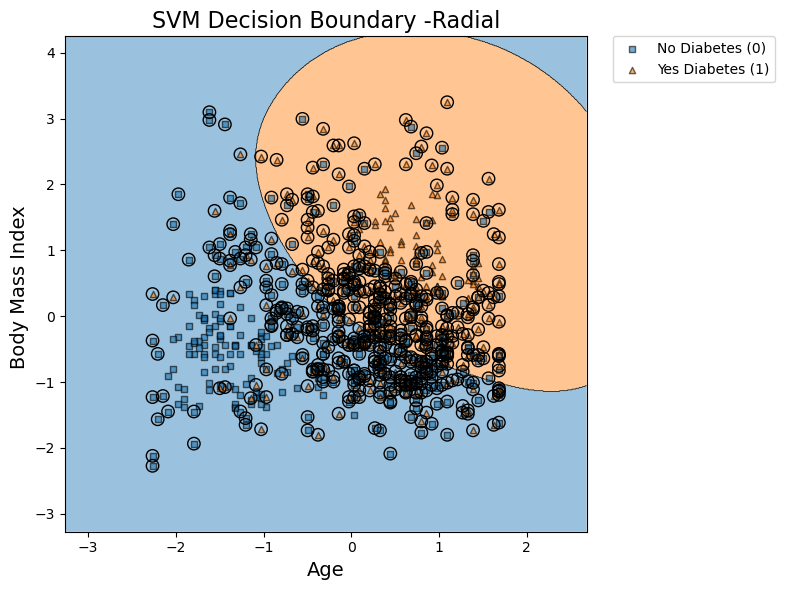

Test Accuracy on Sampled Data: 0.6133


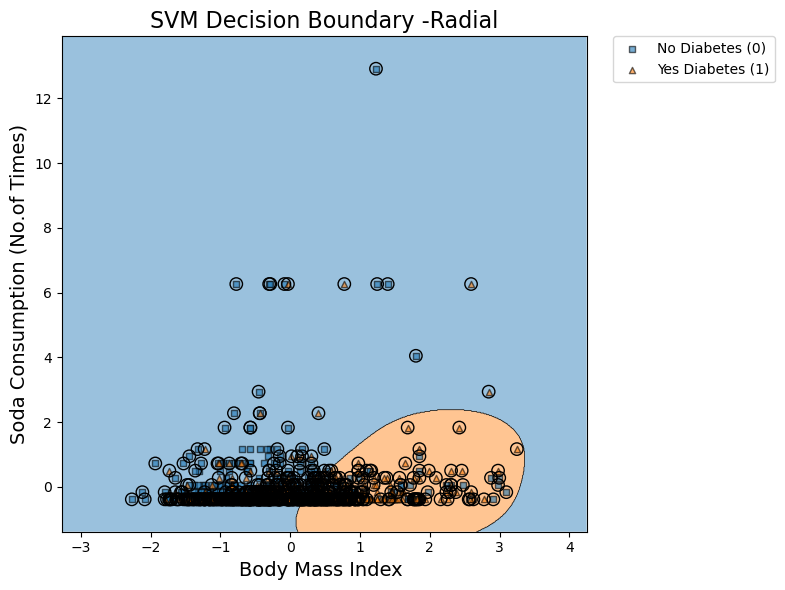

Test Accuracy on Sampled Data: 0.6067


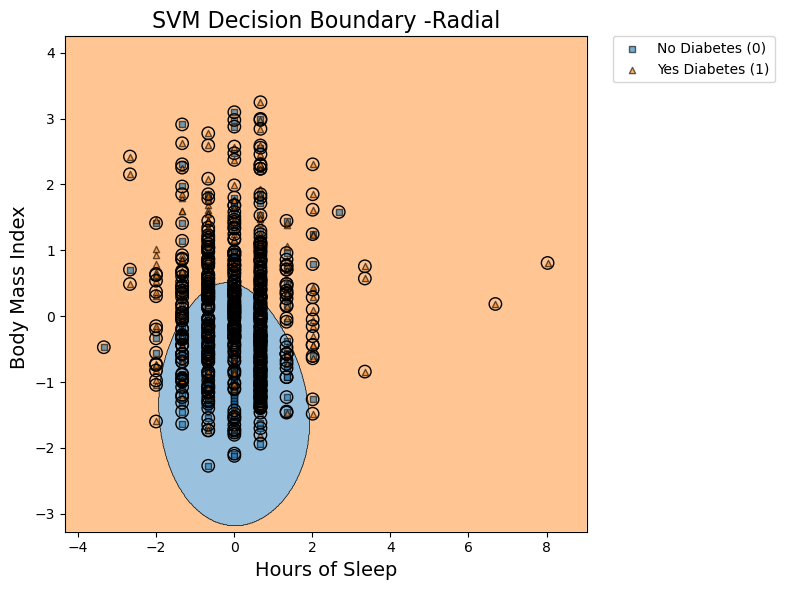

In [24]:

# Human-readable label mapping
label_mapping = {
    'AGE': 'Age',
    'BMICALC': 'Body Mass Index ',
    'HRSLEEP': 'Hours of Sleep',
    'SODAPNO': 'Soda Consumption (No.of Times)',
    'DIABETICEV': 'Diabetes Status'
}

def plot_decision_boundary_rbf(data, feature1, feature2, target):
    X = data[[feature1, feature2]]
    y = data[target]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Radial (RBF) SVM Model with balanced class weight and best C
    svm_model = SVC(kernel='rbf', C=best_C)
    svm_model.fit(X_train_scaled, y_train)

    # Test set accuracy
    y_pred_test = svm_model.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    print(f"Test Accuracy on Sampled Data: {test_accuracy:.4f}")

    # Plot
    plt.figure(figsize=(8, 6))
    plot_decision_regions(X_train_scaled, y_train.to_numpy(), clf=svm_model,
                          legend=2, hide_spines=False,
                          X_highlight=svm_model.support_vectors_,
                          scatter_kwargs={'s': 20, 'edgecolor': 'k', 'alpha': 0.6})

    plt.xlabel(label_mapping.get(feature1, feature1), fontsize=14)
    plt.ylabel(label_mapping.get(feature2, feature2), fontsize=14)
    plt.title('SVM Decision Boundary -Radial', fontsize=16)
    plt.xlim(X_train_scaled[:, 0].min() - 1, X_train_scaled[:, 0].max() + 1)
    plt.ylim(X_train_scaled[:, 1].min() - 1, X_train_scaled[:, 1].max() + 1)
    plt.legend(['No Diabetes (0)', 'Yes Diabetes (1)'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()

# Considering sample data to avaoid overlapping in plots
sampled_data = balanced_data.sample(n=1000, random_state=42)

# Plotting for strongest predictor pairs in radial
plot_decision_boundary_rbf(sampled_data, 'AGE', 'BMICALC', 'DIABETICEV')
plot_decision_boundary_rbf(sampled_data, 'BMICALC', 'SODAPNO', 'DIABETICEV')
plot_decision_boundary_rbf(sampled_data, 'HRSLEEP', 'BMICALC', 'DIABETICEV')


###SVM-POLYNOMIAL

In [25]:
svm_model_poly = SVC(kernel='poly', C=1, degree=3, gamma='scale', cache_size=1000, verbose=True, max_iter=100000 )
svm_model_poly.fit(X_train_scaled, y_train)

[LibSVM]

SVC(C=1, cache_size=1000, kernel='poly', max_iter=100000, verbose=True)

In [26]:
#Prediction on train set
y_pred_train_ploy = svm_model_poly.predict(X_train_scaled)

print("Training Set Classification Report: POLYNOMIAL")
print(classification_report(y_train, y_pred_train_ploy, target_names=['No Diabetes', 'Yes Diabetes']))
accuracy = accuracy_score(y_train, y_pred_train_ploy)
print("PLOYNOMIAL-Training Set Accuracy:", accuracy)

Training Set Classification Report: POLYNOMIAL
              precision    recall  f1-score   support

 No Diabetes       0.73      0.63      0.68      1736
Yes Diabetes       0.68      0.77      0.72      1771

    accuracy                           0.70      3507
   macro avg       0.71      0.70      0.70      3507
weighted avg       0.71      0.70      0.70      3507

PLOYNOMIAL-Training Set Accuracy: 0.7028799543769604


In [27]:
# Predictions on the Test Set
y_pred_test_poly = svm_model_poly.predict(X_test_scaled)

print("Testing Set Classification Report: POLYNOMIAL")
print(classification_report(y_test, y_pred_test_poly, target_names=['No Diabetes', 'Yes Diabetes']))
accuracy = accuracy_score(y_test, y_pred_test_poly)
print("POLYNOMIAL-Testing Set Accuracy:", accuracy)


Testing Set Classification Report: POLYNOMIAL
              precision    recall  f1-score   support

 No Diabetes       0.72      0.65      0.68       769
Yes Diabetes       0.67      0.73      0.70       734

    accuracy                           0.69      1503
   macro avg       0.69      0.69      0.69      1503
weighted avg       0.69      0.69      0.69      1503

POLYNOMIAL-Testing Set Accuracy: 0.6899534264803726


In [28]:
#Performing training and testing error
y_pred_train_poly = svm_model_poly.predict(X_train_scaled)
y_pred_test_poly = svm_model_poly.predict(X_test_scaled)

training_accuracy = accuracy_score(y_train, y_pred_train_poly)
test_accuracy = accuracy_score(y_test, y_pred_test_poly)

training_error = 1 - training_accuracy
test_error = 1 - test_accuracy

print("POLYNOMIAL-Training Error:", training_error)
print("POLYNOMIAL-Test Error:", test_error)


POLYNOMIAL-Training Error: 0.2971200456230396
POLYNOMIAL-Test Error: 0.3100465735196274


In [29]:
#Tuning polynomial kernal
# Empty list to store results
results = []

# Tuning C, gamma, and degree for polynomial kernel
C_values = [0.1, 1, 10]
gamma_values = [0.1, 1]
degree_values = [2, 3]

for C in C_values:
    for gamma in gamma_values:
        for degree in degree_values:
            svm_model_tune_poly = SVC(kernel='poly', C=C, degree=degree, gamma=gamma)
            svm_model_tune_poly.fit(X_train_scaled, y_train)
            accuracy = svm_model_tune_poly.score(X_test_scaled, y_test)
            results.append((C, gamma, degree, accuracy))
            print(f"C={C}, gamma={gamma}, degree={degree} => Accuracy: {accuracy:.4f}")

# Find the best set based on maximum accuracy
best_C, best_gamma, best_degree, best_accuracy = max(results, key=lambda x: x[3])

print("\nBest C:", best_C)
print("Best Gamma:", best_gamma)
print("Best Degree:", best_degree)
print("Best Test Accuracy:", best_accuracy)




C=0.1, gamma=0.1, degree=2 => Accuracy: 0.5762
C=0.1, gamma=0.1, degree=3 => Accuracy: 0.6587
C=0.1, gamma=1, degree=2 => Accuracy: 0.5815
C=0.1, gamma=1, degree=3 => Accuracy: 0.6880
C=1, gamma=0.1, degree=2 => Accuracy: 0.5788
C=1, gamma=0.1, degree=3 => Accuracy: 0.6880
C=1, gamma=1, degree=2 => Accuracy: 0.5822
C=1, gamma=1, degree=3 => Accuracy: 0.6886
C=10, gamma=0.1, degree=2 => Accuracy: 0.5815
C=10, gamma=0.1, degree=3 => Accuracy: 0.6893
C=10, gamma=1, degree=2 => Accuracy: 0.5822
C=10, gamma=1, degree=3 => Accuracy: 0.6900

Best C: 10
Best Gamma: 1
Best Degree: 3
Best Test Accuracy: 0.6899534264803726


In [30]:
# Train the SVM model with a polynomial kernel using the best hyperparameters
svm_model_tuned_poly = SVC(kernel='poly', C=best_C, degree=best_degree, gamma=best_gamma)
svm_model_tuned_poly.fit(X_train_scaled, y_train)

# Make predictions on the training and test sets
y_pred_train_tuned_poly = svm_model_tuned_poly.predict(X_train_scaled)
y_pred_test_tuned_poly = svm_model_tuned_poly.predict(X_test_scaled)

# Calculate the accuracy scores
training_accuracy_tuned_poly = accuracy_score(y_train, y_pred_train_tuned_poly)
testing_accuracy_tuned_poly = accuracy_score(y_test, y_pred_test_tuned_poly)

# Calculate the errors
training_error_tuned_poly = 1 - training_accuracy_tuned_poly
test_error_tuned_poly = 1 - testing_accuracy_tuned_poly

print("\nClassification Report on Training Set (Tuned Model): POLYNOMIAL")
print(classification_report(y_train, y_pred_train_tuned_poly, target_names=['No Diabetes', 'Yes Diabetes']))

print("POLYNOMIAL-Tuned Model Training Accuracy:", training_accuracy_tuned_poly)

print("\nClassification Report on Test Set (Tuned Model): POLYNOMIAL")
print(classification_report(y_test, y_pred_test_tuned_poly, target_names=['No Diabetes', 'Yes Diabetes']))

print("POLYNOMIAL-Tuned Model Test Accuracy:", testing_accuracy_tuned_poly)

# Print the errors
print("POLYNOMIAL-Tuned Model Training Error:", training_error_tuned_poly)
print("POLYNOMIAL-Tuned Model Test Error :", test_error_tuned_poly)


Classification Report on Training Set (Tuned Model): POLYNOMIAL
              precision    recall  f1-score   support

 No Diabetes       0.74      0.63      0.68      1736
Yes Diabetes       0.68      0.78      0.73      1771

    accuracy                           0.70      3507
   macro avg       0.71      0.70      0.70      3507
weighted avg       0.71      0.70      0.70      3507

POLYNOMIAL-Tuned Model Training Accuracy: 0.7043056743655546

Classification Report on Test Set (Tuned Model): POLYNOMIAL
              precision    recall  f1-score   support

 No Diabetes       0.72      0.64      0.68       769
Yes Diabetes       0.66      0.74      0.70       734

    accuracy                           0.69      1503
   macro avg       0.69      0.69      0.69      1503
weighted avg       0.69      0.69      0.69      1503

POLYNOMIAL-Tuned Model Test Accuracy: 0.6899534264803726
POLYNOMIAL-Tuned Model Training Error: 0.2956943256344454
POLYNOMIAL-Tuned Model Test Error : 0.310046

In [31]:
# Predict test set labels using the tuned SVM model with polynomial kernel
y_pred_test_tuned_poly = svm_model_tuned_poly.predict(X_test_scaled)

# Calculate the confusion matrix
conf_matrix_poly = confusion_matrix(y_test, y_pred_test_tuned_poly)

# Print the confusion matrix
print("Confusion Matrix: POLYNOMIAL")
print(conf_matrix_poly)

Confusion Matrix: POLYNOMIAL
[[494 275]
 [191 543]]


Test Accuracy on Sampled Data: 0.7300


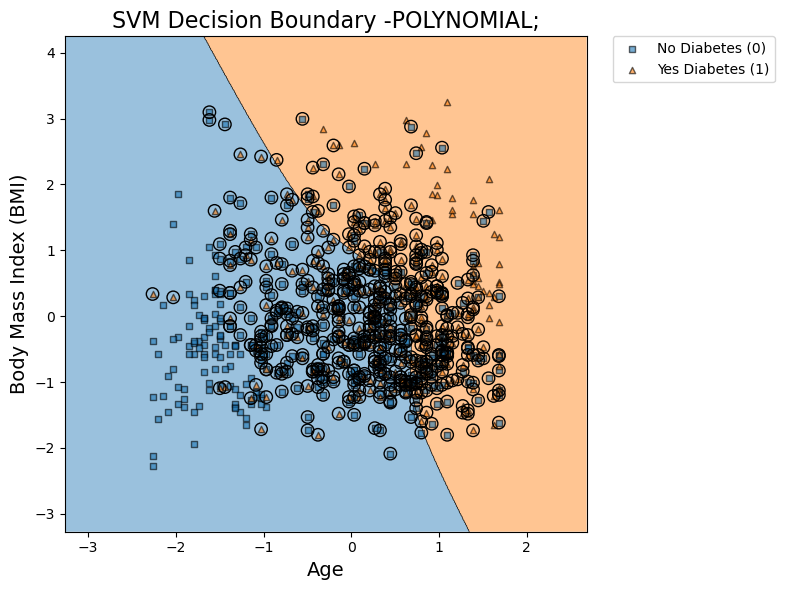

Test Accuracy on Sampled Data: 0.6733


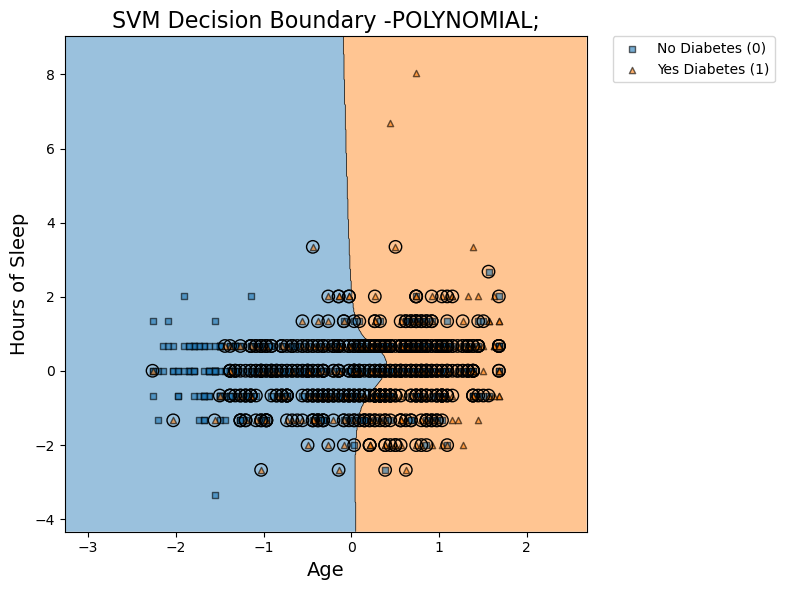

Test Accuracy on Sampled Data: 0.5300


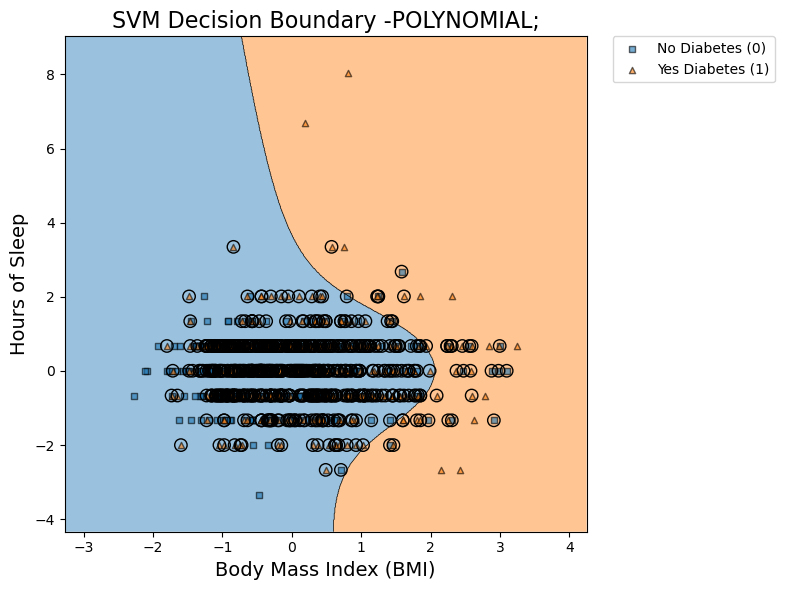

In [32]:
label_mapping = {
    'AGE': 'Age',
    'BMICALC': 'Body Mass Index (BMI)',
    'HRSLEEP': 'Hours of Sleep',
    'SODAPNO': 'Soda Consumption (No. of Times)',
    'DIABETICEV': 'Diabetes Status'
}

def plot_decision_boundary_poly(data, feature1, feature2, target):
    X = data[[feature1, feature2]]
    y = data[target]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Polynomial SVM Model with best C,degree and gamma for tuning
    svm_model = SVC(kernel='poly', C=best_C, degree=best_degree, gamma=best_gamma)
    svm_model.fit(X_train_scaled, y_train)

    # Accuracy on the test set
    y_pred_test = svm_model.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    print(f"Test Accuracy on Sampled Data: {test_accuracy:.4f}")

    # Plotting the decision boundary
    plt.figure(figsize=(8, 6))
    plot_decision_regions(X_train_scaled, y_train.to_numpy(), clf=svm_model,
                          legend=2, hide_spines=False,
                          X_highlight=svm_model.support_vectors_,
                          scatter_kwargs={'s': 20, 'edgecolor': 'k', 'alpha': 0.6})

    plt.xlabel(label_mapping.get(feature1, feature1), fontsize=14)
    plt.ylabel(label_mapping.get(feature2, feature2), fontsize=14)
    plt.title('SVM Decision Boundary -POLYNOMIAL;', fontsize=16)
    plt.xlim(X_train_scaled[:, 0].min() - 1, X_train_scaled[:, 0].max() + 1)
    plt.ylim(X_train_scaled[:, 1].min() - 1, X_train_scaled[:, 1].max() + 1)
    plt.legend(['No Diabetes (0)', 'Yes Diabetes (1)'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()

# Considering sample data to avaoid overlapping in plots
sampled_data = balanced_data.sample(n=1000, random_state=42)

plot_decision_boundary_poly(sampled_data, 'AGE', 'BMICALC', 'DIABETICEV')
plot_decision_boundary_poly(sampled_data, 'AGE', 'HRSLEEP', 'DIABETICEV')
plot_decision_boundary_poly(sampled_data, 'BMICALC', 'HRSLEEP', 'DIABETICEV')
